In [3]:
import os
os.chdir(r'C:\Users\ydool\Repos\sensor-analysis-assignment')

In [5]:
from extract_features import process_dataset, load_and_process_sample
from visualization import signal_viewer
from imu_pipeline import IMUPipeline
from pathlib import Path
import pandas as pd
import joblib
import os

In [6]:
signal_viewer(
    data_dir=Path('data/raw/train'),
    labels_csv=Path('data/train.csv')
)

# ❓ Questions to Reflect On


- What do you observe when comparing the model’s predictions on the new data to its known performance?

- Is there anything in the data that might explain differences in behavior?

- Can you identify patterns or trends related to when the model succeeds or fails?

- Are there signals or features that seem to affect the model’s reliability?

- What could be done in the short term to handle the current situation?

- What are potential long-term steps to improve model performance in similar scenarios?

- What would you want to explore further if given more time or data?

- What assumptions did the model rely on during training — and are they still valid?

# Analysis of test data vs. inference data #
### note: I used chatGPT to understand what the columns are, as I couldn't find a description of the columns in the task. So if a column is misinterpreted that's a context-availability problem as I am unfamliar with this data. ###


### Main Finding ###
Seems the performance difference between the inference and test data, is that the driver-vehicle metadata for inference data is somehow mangled. The clearest way to see this to look at features that should remain consistent for a vehicle across different lines in the data - device_model, calibration_status, firmware_version, sensor_source, network_type.
For example, when filtering  for driver_id=D1071 in both datasets on these features and deduping,you can see that in the inference dataset for example the SUV and sedan have different models, different firmware vesions, different network types, while the same filter from the test data provides exactly one row for each vehicle, and each vehicle has exactly one sensor source, firmware version, etc as expected. 

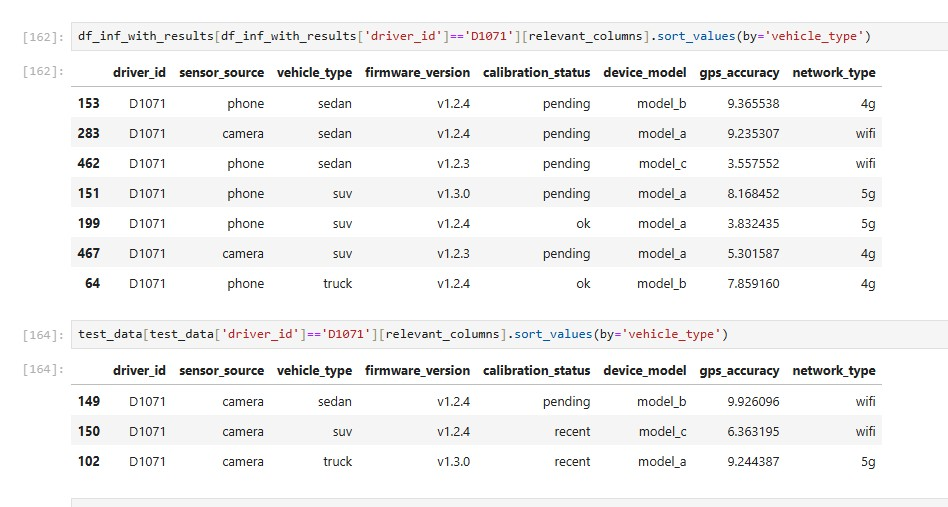

In [13]:
from IPython.display import Image

# Specify the image path (it could be a local file or a URL)
Image(filename='screenshot.jpg')

My best guess and intuition here is that something went wrong with this data in the pipeline or it arrived corrupted in the pipeline. I don't have access to the source of truth data so can't say for sure what's the root cause but those would be my first suspects.

### short term solutions ###
Remove from the training and testing data all rows that arrived in the same batch as the inference table data, flag them as unusable and possibly delete them from the database. There are no overlapping session_ids with the test data so this shouldn't affect the good data.
### Longer term solutions ###
1) Check for these issues in all available data, find the root cause and fix it
2) Add monitoring and validation scripts that catch this kind of inconsistency as it arrives

## EDA summary ##
1) Features that correlate with worse model performance: older firmware versions, time of day being afternoon (suggestion in-between lighting conditions are problematic for the model), SUV vehicle type, fog weather (which is completely expected, it also reduces human performance)
##### Action Item:  Adding afternoon sessions, vehicles with older firmware versions, and SUV vehicles to the training data would probably improve performance. #####
2) More features that correlate with worse model predictions: x_n_peaks, z_skew, z_min, z_mean, z_fft_max, z_energy, yu_fft_max, xz_corr - according to chatGPT these are features relating to vertical movement, sudden de-acceleration, signal peaks that could be caused by vibrations/impacts/events. What I understand from this is that the model doesn't give good predictions on crashes and near-crashes, which is actually one of the top reasons someone might want to get a Nexar Dashcam, so this is hugely problematic.
##### Action Item: train heavily on crash and near-crash events in P1 priority. #####


## Further exploration with more time and data ##
Having more time and data - also more rows and also more features - I'd like to look at performance with the following:
1) Road types - highways, residential streets, dirt roads - different roads mean different movement types.
2) More vehicle context - model+year (for example the small 2006 hyundai i used to have would wobble with high winds in a way I've yet to experience with other cars since), vehicle size class, electric vs. gas cars, etc
3) More info on weather conditions - things like strong wind could potentially affect car movements (at least for 2006 hyundai car i once had)



## Model assumptions ##
I don't know for sure the assumptions in the training data, but guessing from the performance I've seen it seems the assumptions were that a private car is generally smaller than an SUV, driving happens in the morning or at night, and post people have the latest firmware installed. These assumptions don't cover everything and the training data needs to be diversified. 